# `dask` Experiments on SalishSeaCast Results

This notebook explores how to use `dask` and `xarray.open_mfdataset()` to 

The packages required by this notebook are defined in the `conda` environment file `analysis-doug/notebooks/dask-expts/environment.yaml` along with instructions on how to created an isolated environment containing the latest versions of those packages.
The `analysis-doug/notebooks/dask-expts/requirements.txt` contains a complete list of all of the packages (top level and dependecies) and their versions that were used most recently for work in this notebook. 

In [27]:
%matplotlib inline

In [67]:
import time

import xarray
from dask.distributed import Client

In [121]:
client = Client(n_workers=2, threads_per_worker=2, memory_limit='4GB')
client

/media/doug/warehouse/conda_envs/dask-expts/lib/python3.8/site-packages/distributed/dashboard/core.py:72: UserWarning: 
Port 8787 is already in use. 
Perhaps you already have a cluster running?
Hosting the diagnostics dashboard on a random port instead.
  warnings.warn("\n" + msg)


Client Scheduler: tcp://127.0.0.1:44913 Dashboard: http://127.0.0.1:37805/status,Cluster Workers: 2 Cores: 4 Memory: 8.00 GB


In [6]:
ds = xarray.open_dataset("/tmp/dask-expts/SalishSea_1h_20150101_20150101_grid_T.nc")    

In [7]:
ds

<xarray.Dataset>
Dimensions:               (axis_nbounds: 2, deptht: 40, nvertex: 4, time_counter: 24, x: 398, y: 898)
Coordinates:
    nav_lat               (y, x) float32 ...
    nav_lon               (y, x) float32 ...
  * deptht                (deptht) float32 0.5000003 1.5000031 ... 441.4661
    time_centered         (time_counter) datetime64[ns] ...
  * time_counter          (time_counter) datetime64[ns] 2015-01-01T00:30:00 ... 2015-01-01T23:30:00
Dimensions without coordinates: axis_nbounds, nvertex, x, y
Data variables:
    bounds_lon            (y, x, nvertex) float32 ...
    bounds_lat            (y, x, nvertex) float32 ...
    area                  (y, x) float32 ...
    deptht_bounds         (deptht, axis_nbounds) float32 ...
    sossheig              (time_counter, y, x) float32 ...
    time_centered_bounds  (time_counter, axis_nbounds) datetime64[ns] ...
    time_counter_bounds   (time_counter, axis_nbounds) datetime64[ns] ...
    votemper              (time_counter, dept

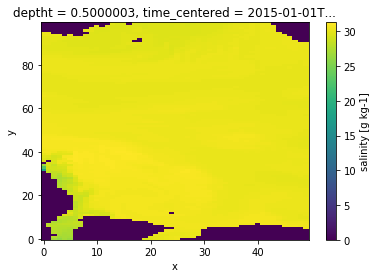

In [13]:
ds.vosaline.isel(time_counter=0, deptht=0, y=slice(200, 300), x=slice(200,250)).plot()

In [14]:
ds.vosaline.isel(time_counter=0, y=slice(200, 300), x=slice(200,250))

<xarray.DataArray 'vosaline' (deptht: 40, y: 100, x: 50)>
[200000 values with dtype=float32]
Coordinates:
    nav_lat        (y, x) float32 ...
    nav_lon        (y, x) float32 ...
  * deptht         (deptht) float32 0.5000003 1.5000031 ... 414.5341 441.4661
    time_centered  datetime64[ns] ...
    time_counter   datetime64[ns] 2015-01-01T00:30:00
Dimensions without coordinates: y, x
Attributes:
    standard_name:       sea_water_reference_salinity
    long_name:           salinity
    units:               g kg-1
    online_operation:    average
    interval_operation:  40 s
    interval_write:      1 h
    cell_methods:        time: mean (interval: 40 s)
    cell_measures:       area: area

In [15]:
ds.vosaline.isel(time_counter=0, y=slice(200, 300), x=slice(200,250)).mean(dim="deptht")

<xarray.DataArray 'vosaline' (y: 100, x: 50)>
array([[0.      , 0.      , 7.462555, ..., 0.      , 0.      , 0.      ],
       [0.      , 0.      , 4.382652, ..., 0.      , 0.      , 0.      ],
       [0.      , 0.      , 0.      , ..., 0.      , 0.      , 0.      ],
       ...,
       [0.      , 0.      , 0.      , ..., 0.      , 0.      , 0.      ],
       [0.      , 0.      , 0.      , ..., 0.      , 0.      , 0.      ],
       [0.      , 0.      , 0.      , ..., 0.      , 0.      , 0.      ]],
      dtype=float32)
Coordinates:
    nav_lat        (y, x) float32 ...
    nav_lon        (y, x) float32 ...
    time_centered  datetime64[ns] ...
    time_counter   datetime64[ns] 2015-01-01T00:30:00
Dimensions without coordinates: y, x

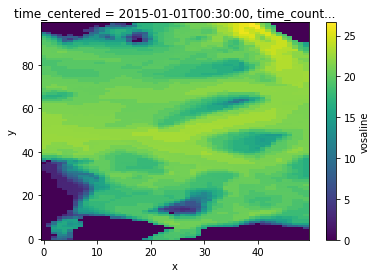

In [16]:
ds.vosaline.isel(time_counter=0, y=slice(200, 300), x=slice(200,250)).mean(dim="deptht").plot()

In [23]:
%%time
depth_avgs = ds.vosaline.isel(y=slice(200, 300), x=slice(200,250)).mean(dim="deptht")

CPU times: user 6.24 s, sys: 1.36 s, total: 7.6 s
Wall time: 7.62 s


In [24]:
ds.close()

In [73]:
t_start = time.time()
with xarray.open_dataset("/tmp/dask-expts/SalishSea_1h_20150101_20150101_grid_T.nc") as ds:
    depth_avgs = ds.vosaline.isel(y=slice(200, 300), x=slice(200,250)).mean(dim="deptht")
t_end = time.time()
print(t_end - t_start)

7.867188930511475


In [69]:
ds = xarray.open_dataset(
    "/tmp/dask-expts/SalishSea_1h_20150101_20150101_grid_T.nc",
    chunks={"time_counter": 3, "deptht": 40, "y": 100, "x": 50}
)
ds

<xarray.Dataset>
Dimensions:               (axis_nbounds: 2, deptht: 40, nvertex: 4, time_counter: 24, x: 398, y: 898)
Coordinates:
    nav_lat               (y, x) float32 dask.array<chunksize=(100, 50), meta=np.ndarray>
    nav_lon               (y, x) float32 dask.array<chunksize=(100, 50), meta=np.ndarray>
  * deptht                (deptht) float32 0.5000003 1.5000031 ... 441.4661
    time_centered         (time_counter) datetime64[ns] dask.array<chunksize=(3,), meta=np.ndarray>
  * time_counter          (time_counter) datetime64[ns] 2015-01-01T00:30:00 ... 2015-01-01T23:30:00
Dimensions without coordinates: axis_nbounds, nvertex, x, y
Data variables:
    bounds_lon            (y, x, nvertex) float32 dask.array<chunksize=(100, 50, 4), meta=np.ndarray>
    bounds_lat            (y, x, nvertex) float32 dask.array<chunksize=(100, 50, 4), meta=np.ndarray>
    area                  (y, x) float32 dask.array<chunksize=(100, 50), meta=np.ndarray>
    deptht_bounds         (deptht, axis_nb

In [70]:
ds.vosaline.data

,Array,Chunk
Bytes,1.37 GB,2.40 MB
Shape,"(24, 40, 898, 398)","(3, 40, 100, 50)"
Count,577 Tasks,576 Chunks
Type,float32,numpy.ndarray


In [71]:
depth_avgs = ds.vosaline.isel(y=slice(200, 300), x=slice(200,250)).mean(dim="deptht")

In [85]:
t_start = time.time()
ds = xarray.open_dataset(
    "/tmp/dask-expts/SalishSea_1h_20150101_20150101_grid_T.nc",
    chunks={"time_counter": 1, "deptht": 40, "y": 100, "x": 50}
)
depth_avgs = ds.vosaline.isel(y=slice(200, 300), x=slice(200,250)).mean(dim="deptht")
depth_avgs.compute()
t_end = time.time()
print(t_end - t_start)

5.554843187332153


In [86]:
depth_avgs

<xarray.DataArray 'vosaline' (time_counter: 24, y: 100, x: 50)>
dask.array<mean_agg-aggregate, shape=(24, 100, 50), dtype=float32, chunksize=(1, 100, 50), chunktype=numpy.ndarray>
Coordinates:
    nav_lat        (y, x) float32 dask.array<chunksize=(100, 50), meta=np.ndarray>
    nav_lon        (y, x) float32 dask.array<chunksize=(100, 50), meta=np.ndarray>
    time_centered  (time_counter) datetime64[ns] dask.array<chunksize=(1,), meta=np.ndarray>
  * time_counter   (time_counter) datetime64[ns] 2015-01-01T00:30:00 ... 2015-01-01T23:30:00
Dimensions without coordinates: y, x

In [122]:
t_start = time.time()
ds = xarray.open_mfdataset(
    ("/tmp/dask-expts/SalishSea_1h_20150101_20150101_grid_T.nc",
     "/tmp/dask-expts/SalishSea_1h_20150102_20150102_grid_T.nc",
     "/tmp/dask-expts/SalishSea_1h_20150103_20150103_grid_T.nc",
     "/tmp/dask-expts/SalishSea_1h_20150104_20150104_grid_T.nc",
    ),
#     chunks={"time_counter": 12, "deptht": 40, "y": 100, "x": 50},
    combine="nested", concat_dim="time_counter", parallel=False,
)
depth_avgs = ds.vosaline.isel(y=slice(200, 300), x=slice(200,250)).mean(dim="deptht")
depth_avgs.compute()
t_end = time.time()
print(t_end - t_start)

29.101138591766357


In [115]:
datasets = ("/tmp/dask-expts/SalishSea_1h_20150101_20150101_grid_T.nc",
     "/tmp/dask-expts/SalishSea_1h_20150102_20150102_grid_T.nc",
     "/tmp/dask-expts/SalishSea_1h_20150103_20150103_grid_T.nc",
     "/tmp/dask-expts/SalishSea_1h_20150104_20150104_grid_T.nc",
    )
t_start = time.time()
for dataset in datasets:
    with xarray.open_dataset(dataset) as ds:
        depth_avgs = ds.vosaline.isel(y=slice(200, 300), x=slice(200,250)).mean(dim="deptht")
t_end = time.time()
print(t_end - t_start)

31.323386669158936
